

# Project: Investigate TMDB Movie Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Setup the imports and load the data

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df_movies = pd.read_csv("tmdb-movies.csv")

# Glancing at few lines of data for a basic understanding
df_movies.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


### Description of the dataset

The dataset analysed here is taken from TMDB dataset (originally taken from [this kaggle data set](https://www.kaggle.com/tmdb/tmdb-movie-metadata)). It has about 10K+ entries and has multiple dependent variables such as `revenue`, `vote_count`, `vote_average` and `popularity`. Some of the fields such as `cast` are a list of strings concatenated with pipeline (`|`) character. This dataset has movies spanned over for nearly 40 years since 1960.

### Things to explore

* Looking at the initial snapshot, we can probably try to use the `revenue` metric as our dependent variable as this would gauge the performance of the movie. We can keep other variables in mind such as `vote_average`, `vote_count` and `popularity` which can be considered as the dependent variable as well.
* After we decide on a dependent variable, we can choose to explore the correlation of this variable against other independent variables such as
    * runtime
    * genres
    * cast
    * director
    * production studio
* We can build concrete questions once we dive deep in to the actual dataset.

<a id='wrangling'></a>
## Data Wrangling

In [49]:
#Playing around to further understand the data.
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

### Preliminary observations from dataset

Looking at the output of the info() call we can make the following deductions:

* `Homepage` label is null for 75% of the movies. `Overview`field is missing for few moviesas well. Both these columns do not provide any insights to the context of our analysis here, and we should be able to safely drop these columns.
* `Imdb_id` is null for 10 movies but our analysis should be unaffected by presence (or absence) of this field.
* `Production companies`column also  has null values for some of the movies. 
* Only 23 movies (out of 10866) are missing the `genres` field. 76 movies are missing the `cast` field. 48 movies are missing the `director` information. We should be able to safely drop the rows with missing `genres`, `cast` and `director` as well. 
* Lot of entries are missing the `keyword` & `production` fields. It is not possible to fill the data with any trivial pandas or python functions (for e.g.: mean() does not make any sense here). However, It would not be wise to drop the rows. For what its worth, we can perform some tentative analysis for the rows that have empty keyword (or production_companies) fields with low accuracy.

In [50]:
#For finding out any data discrepencies.
df_movies.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


### Deeper analysis into the dataset

Now that we have a brief understanding of the dataset and its columns, we can delve deeper in to each of the features provided and plan our cleanup process.

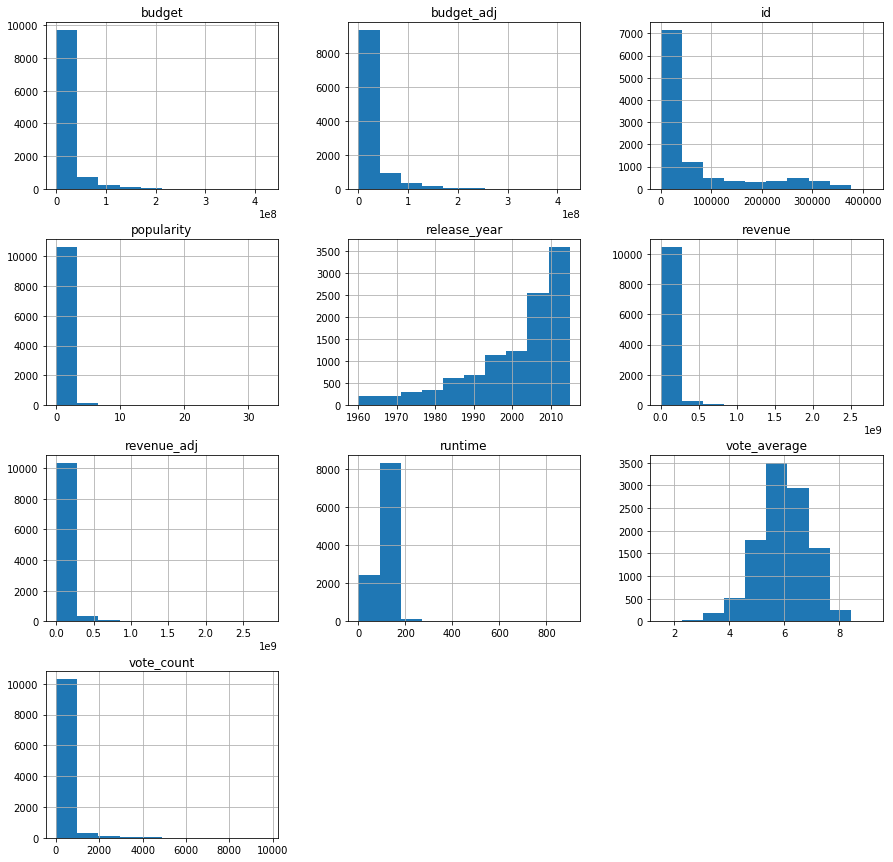

In [51]:
df_movies.hist(figsize=[15, 15]);

In [52]:
#Finds the number of duplicated rows
print("duplicated count : {}".format(sum(df_movies.duplicated())))

duplicated count : 1


#### Duplicated data
* Using the duplicated() method call it is evident that only one entry is duplicated and this can be dropped.

In [53]:
df_movies.describe()["popularity"]

count    10866.000000
mean         0.646441
std          1.000185
min          0.000065
25%          0.207583
50%          0.383856
75%          0.713817
max         32.985763
Name: popularity, dtype: float64

popularity < 1 : 9110
popularity > 1 : 1756
popularity > 10 : 11


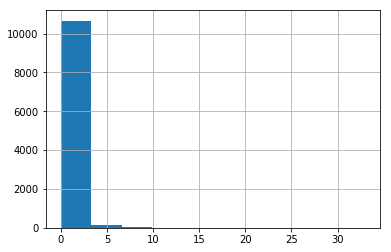

In [54]:
# Querying the data on popularity column to foray into the actual values.
df_movies["popularity"].hist();
print( "popularity < 1 : {}".format(df_movies.query("popularity < 1")["popularity"].count()))
print( "popularity > 1 : {}".format(df_movies.query("popularity > 1")["popularity"].count()))
print( "popularity > 10 : {}".format(df_movies.query("popularity > 10")["popularity"].count()))

#### Errant popularity data
* Using feature based analysis we can see that there is significant discrepancy in the popularity column. Looking at the popularity statistics: 

```
mean         0.646441
std          1.000185
min          0.000065
25%          0.207583
50%          0.383856
75%          0.713817
max         32.985763
```
* Further looking at the histogram for the popularity column leads us to believe that this may be an errant data. While the max is 32, most of the movies are concentrated in the interval of 0 to 1. We can drop this column as it may not provide valuable insights. My best guess is that this errant data could have been generated by merging multiple datasets which used popularity on various scales such as 0 to 1 (could have been simplified percentile rating), 1 to 10 (like the standard IMDb rating) and 0 to 100 (as a rotten tomatoes pure percentile rating). However, this is a strong assumption to make and thus we can't use it to cleanup the popularity field. In conclusion, it is better to drop this column.

In [55]:
df_movies.query("runtime == 0").count()

id                      31
imdb_id                 31
popularity              31
budget                  31
revenue                 31
original_title          31
cast                    31
homepage                 6
director                29
tagline                  5
keywords                15
overview                29
runtime                 31
genres                  30
production_companies    13
release_date            31
vote_count              31
vote_average            31
release_year            31
budget_adj              31
revenue_adj             31
dtype: int64

### Cleanup runtime data

There are 31 entries with zero `runtime` value. It may not be wise to substitute these with mean (or median) as it may affect with the accuracy of analysis process. It is better to just drop these entries as the count is quite low (< 0.01 percent).

In [56]:
# Using Query and count function for zero values.
print("zero budget count : {}".format(df_movies.query("budget == 0")["budget"].count()))
print("zero revenue count : {}".format(df_movies.query("revenue == 0")["revenue"].count()))

zero budget count : 5696
zero revenue count : 6016


### Surprising revelations

Looking at the output of above query and learning that half of our dataset has entries with zero revenue, we might want to re-evaluate our questions. Since more than half of the entries have zero as the revenue, we cannot reasonably substitute the empty values with mean (or median). Hence, we might consider the next best metric to gauge the movie's performance which is the average vote count. Let's look at the statistics for average vote count:

In [57]:
df_movies["vote_average"].describe()

count    10866.000000
mean         5.974922
std          0.935142
min          1.500000
25%          5.400000
50%          6.000000
75%          6.600000
max          9.200000
Name: vote_average, dtype: float64

Looking at above stats, the minimum value is nonzero and highest is close to 10 (this could be because it was taken on a scale of 0 - 10 as a standard imdb rating). Hence we can **consider this as the dependent variable**

### Patterns to explore

Now that we decided on a depedent variable, we can explore following patterns

* Explore the frequency of top:
  * `genres`
  * `cast`
  * `director`
  * `keywords`
  * `production_companies`
* Explore the correlation of `vote_average` against:
  * `genres` of the movies
  * `runtime` of the movies
  * `release_date` of the movies
  * `cast`, `director` : these are special fields because each entry has multiple values seperated by `|`.
  *  `production_companies` : nearly half of our dataset has missing value for `production_companies`. We would perform analysis but it may be highly inaccurate.
* Explore the correlation of `vote_count` against:
  * `release_date` of the movies  (movies being released in holiday seasons could have high watching rate)

<a id='cleaning'></a>
### Data Cleaning

Now that we have explored the dataset and found multiple optimizations that can perform, let's go ahead and apply all of these cleanup operations on our dataset so that can we can make our analysis on a clean dataframe.

In [58]:
# drop the duplicate rows.
df_movies.drop_duplicates(inplace=True)

# drop non insightful columns
drop_columns = ["homepage", "overview", "popularity"]

# drop columns inplace and ignore any errors (makes it easy to rerun)
df_movies.drop(columns=drop_columns, inplace=True, errors="ignore")

# drop rows whose genres field is null
df_movies.dropna(axis=0, how="all", subset=["genres"], inplace=True)

# drop rows whose director field is null
df_movies.dropna(axis=0, how="all", subset=["director"], inplace=True)

# drop rows whose cast field is null
df_movies.dropna(axis=0, how="all", subset=["cast"], inplace=True)

In [59]:
# drop rows whose runtime field is null
runtime_zero = df_movies.query("runtime == 0")
df_movies.drop(index=runtime_zero.index, inplace=True, errors="ignore")
df_movies.shape

(10703, 18)

In [60]:
# Assert that there are no movies with empty genres
assert df_movies["genres"].isnull().sum() == 0

# Assert that there are no movies with empty genres
assert df_movies["director"].isnull().sum() == 0

# Assert that there are no movies with empty genres
assert df_movies["cast"].isnull().sum() == 0

# Assert that there are no movies with zero runtime
assert df_movies.query("runtime == 0").empty

---

<a id='eda'></a>
## Exploratory Data Analysis

### Number of movies released per year

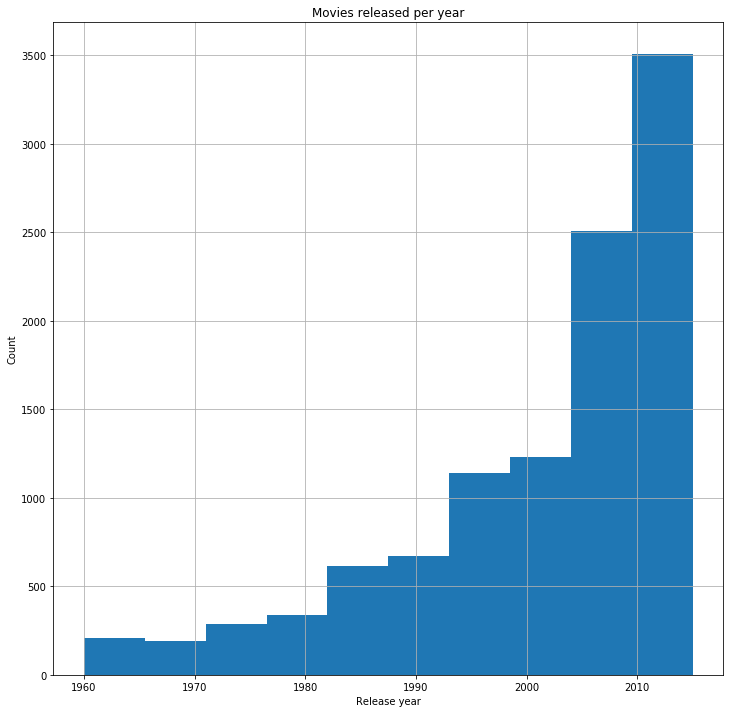

In [61]:
df_movies["release_year"].hist(figsize=[12, 12])
plt.xlabel("Release year")
plt.ylabel("Count")
plt.title("Movies released per year");

As the above graph depicts, the number of movies being released per year has consistently increased.

### Movies being released per month

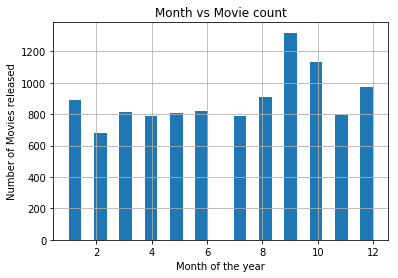

In [62]:
# Use the release_date column and split it with `/` seperator and then
# take the first value (which would be the value for month) and plot a histogram.
release_date_months = df_movies["release_date"].str.split("/", n = 2, expand=True)[0].astype(int)
release_date_months.hist(bins=24);
plt.xlabel("Month of the year")
plt.ylabel("Number of Movies released")
plt.title("Month vs Movie count");

Above graph infers that most number of movies are usually released during the second half of the year (September to January season). That being said, there are no big dips in movie release count with february being the month with least number of movies.

### Does movie release date month affect the vote average ?

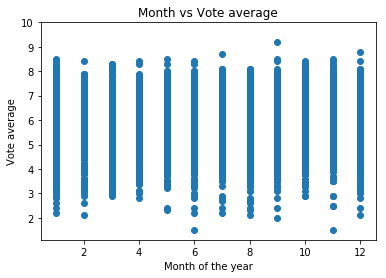

In [63]:
plt.scatter(release_date_months, df_movies.vote_average);
plt.xlabel("Month of the year")
plt.ylabel("Vote average")
plt.ylim(ymax = 10)
plt.title("Month vs Vote average");

Above graph does not infer any high confident correlation between the release date month and vote average

### Is there any relation between the vote_count and the release month of the movie ?

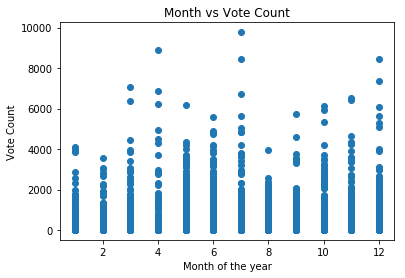

In [64]:
plt.scatter(release_date_months, df_movies.vote_count)
plt.xlabel("Month of the year")
plt.ylabel("Vote Count")
plt.title("Month vs Vote Count");

Again, there are some outliers but there isn't any pattern between the month of the movie release data and the vote count average.

In [65]:
# Define constants reused elsewhere:
column_genres = "genres"
column_vote_average = "vote_average"
column_production_companies = "production_companies"
column_cast = "cast"
column_director = "director"

# This method is used to split values in a given column with the given seperator and then return a
# value counts which would be sorted in descending order of frequency.
def get_value_counts_in_column(name: str, df: pd.DataFrame, sep: str = "|"):
    nonna_df = df.dropna(subset=[name])
    r = nonna_df[name].str.split(sep, expand=True)
    r = r.values.flatten()
    r = r[r != np.array(None)]
    return pd.value_counts(r)


#
# This method creates a dataframe by taking two columns `x` and `y` in a datafram `df`.
# 
# This is the breakdown of functionality of this method:
#  1. Split the column x with the given seperator (only `|` is used in the scope of this notebook).
#  2. Expands the column in to multiple columns based on how many values are genreated from splitting.
#  3. Stack the newly generated columns in to one (thus increasing the number of rows)
#  4. Call Groupby on the column x and only take entires with highest frequency (# of entires is controlled by count parameter)
#  5. Return a dataframe with columns as x and y.
#  
def expand_column(
    x: str, # Usually the independent variable. This column would be splitted and expanded
    y : str, # Usually the dependent variable
    df : pd.DataFrame,
    count : int = -1, # Maximum number of entries to be considered. Defaults to all
    sep: str = "|", # Seperator to split values in columns. Defaults to |
    dropna: bool = True # Drop entries whose values for x are null
):
    new_df = df.copy()
    if dropna:
        new_df.dropna(subset=[x], inplace=True)
    
    value_counts = get_value_counts_in_column(x, new_df, sep).head(count)

    expanded_df = pd.DataFrame(new_df[x].str.split(sep).tolist(), index = new_df[y]).stack()
    expanded_df = expanded_df.reset_index([0, y])
    expanded_df.columns = [y, x]
    d = expanded_df.groupby(by=x).mean()
    d = d.loc[value_counts.index.values]
    new_df = pd.DataFrame(list(zip(d.index.values, d[y].values)), columns =[x, y])
    return new_df

Explore How many movies are produced by (or in) each :
 * Genre
 * Director
 * Actor (or Actress)
 * Production Studio
 
Once we have above, we can explore the correlation of above (or say top 100 if there are too many) with vote_average

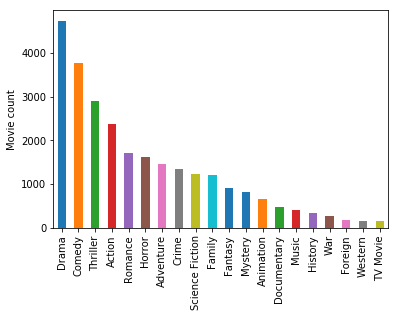

In [66]:
get_value_counts_in_column(column_genres, df_movies).plot.bar()
plt.ylabel("Movie count");

`Drama` and `Comedy` seems to be the genres with most number of movies being released. It would be interesting to see if top genres are indeed the top rated genres as well.

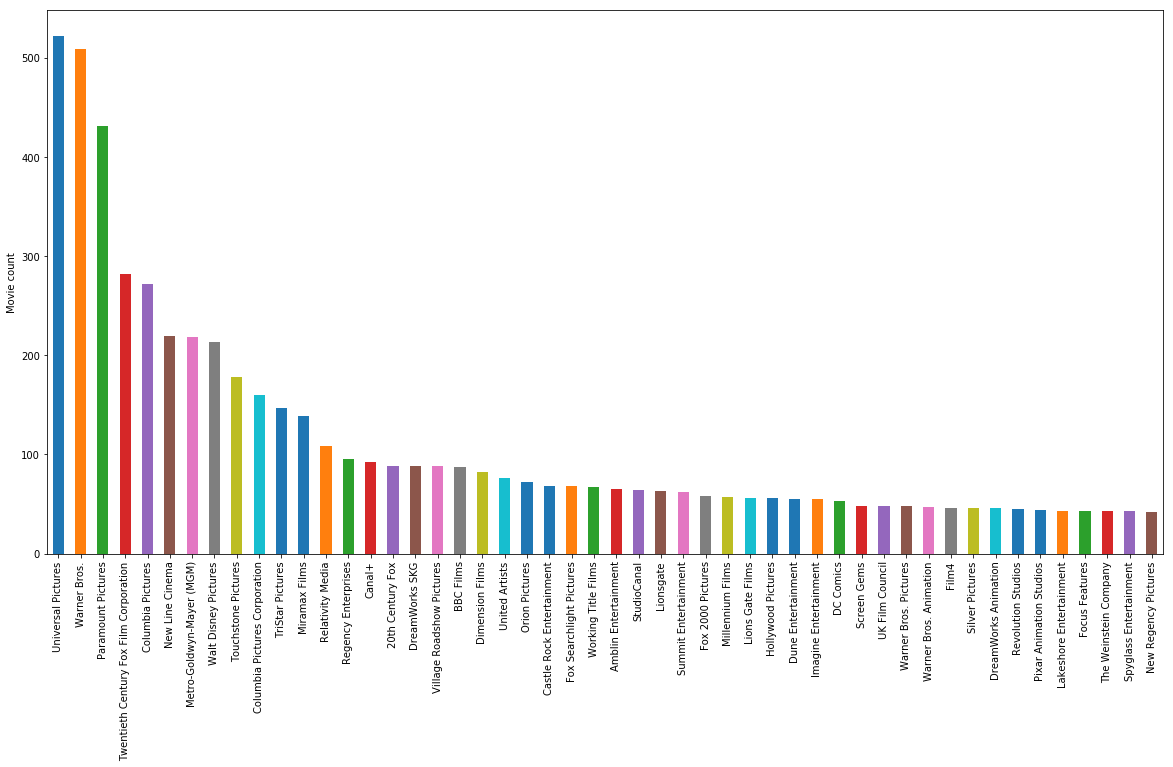

In [67]:
get_value_counts_in_column(column_production_companies, df_movies).head(50).plot.bar(figsize=[20, 10])
plt.ylabel("Movie count");

**NOTE : The production studios information is missing for 10% of the entries. This is a low confidence insight**

Most of the movie releases are from a handful of studios as depicted in the above graph.

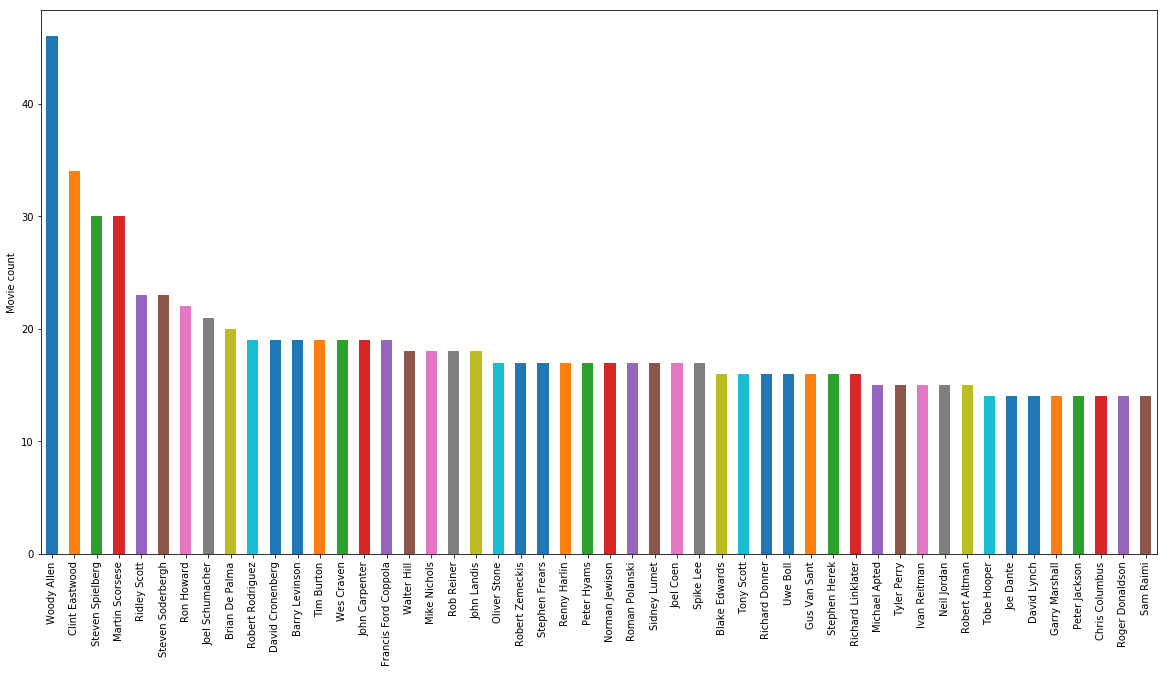

In [68]:
get_value_counts_in_column(column_director, df_movies).head(50).plot.bar(figsize=[20, 10]);
plt.ylabel("Movie count");

`Woody Allen`, `Client Eastwood`, `Martin Scorsese` and `Steven Spielberg` seems to be the directors with most number of movies. It would be interesting to see their correlation with vote average.

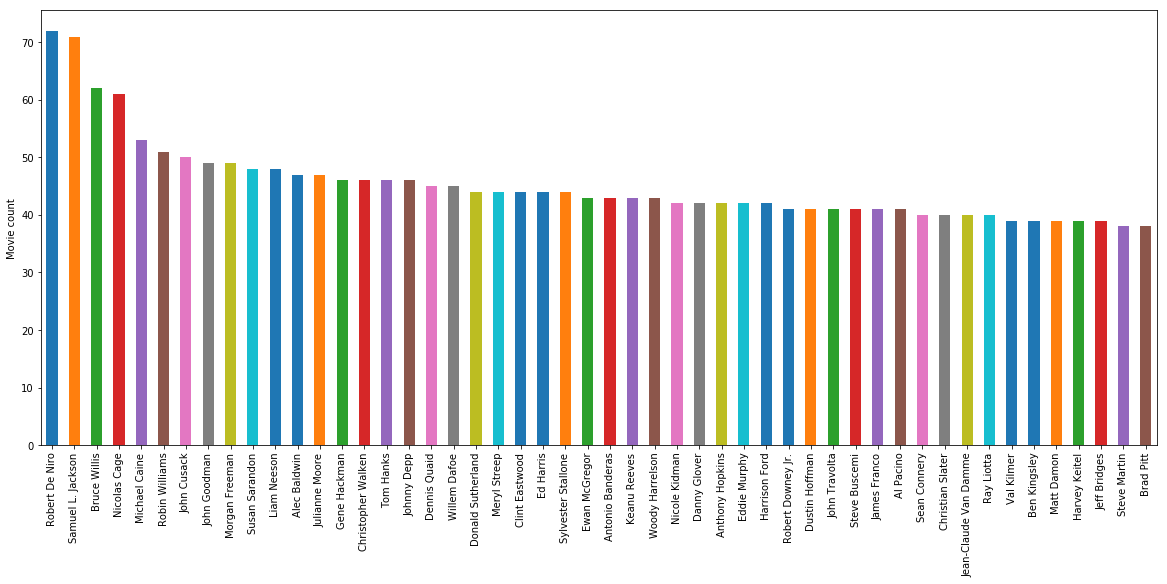

In [69]:
get_value_counts_in_column(column_cast, df_movies).head(50).plot.bar(figsize=[20, 8]);
plt.ylabel("Movie count");

`Robert De Niro`, `Samuel L Jackson`, `Bruce Wills`, `Nicolas Cage` seems to be the top few actors. It is interesting to note that there are no actresses in top 10 (by count of movies).

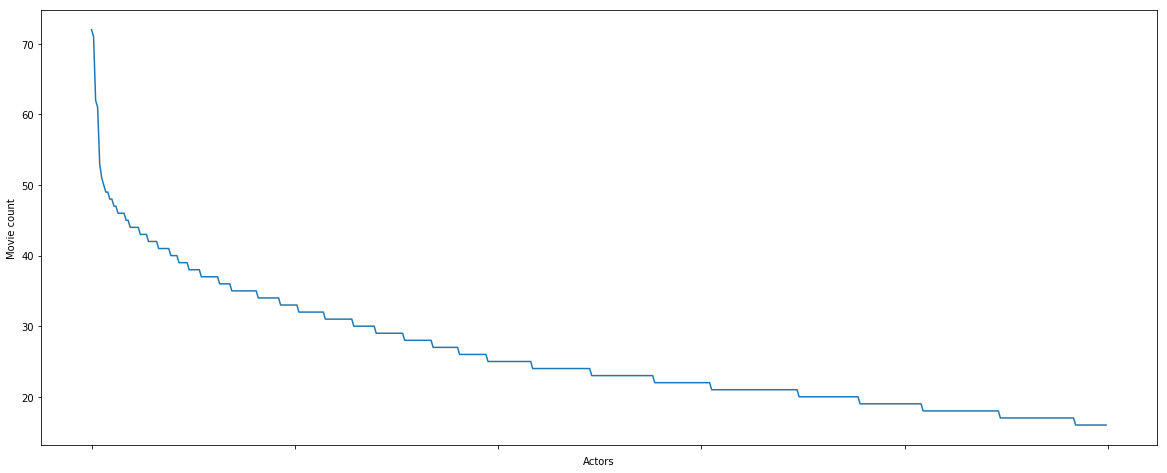

In [70]:
get_value_counts_in_column(column_cast, df_movies).head(500).plot.line(figsize=[20, 8]);
plt.ylabel("Movie count");
plt.xlabel("Actors");

Above line graph that plots nearly 500 actors shows that most of the movies are made by limited number of actors. The diversity is less in the actors as only a handful of actors get to make more and more movies.

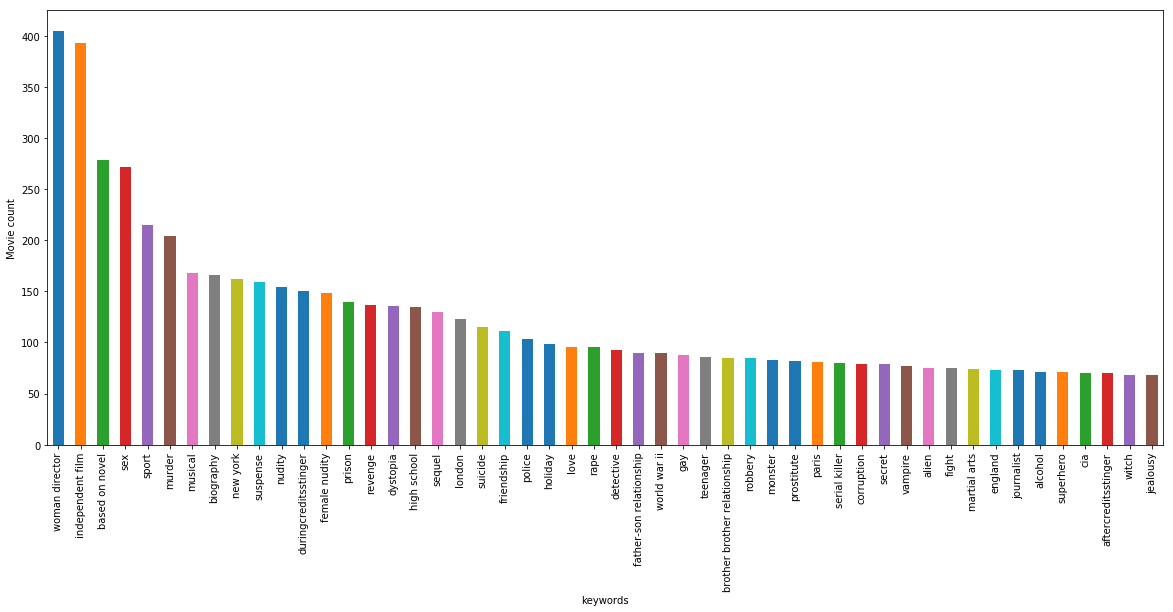

In [71]:
get_value_counts_in_column("keywords", df_movies).head(50).plot.bar(figsize=[20, 8]);
plt.ylabel("Movie count");
plt.xlabel("keywords");

While there were no actresses in the top 10 by cast, it is interesting to see that the highest used keyword is `woman director`.

### Does vote average have any correlation with genres

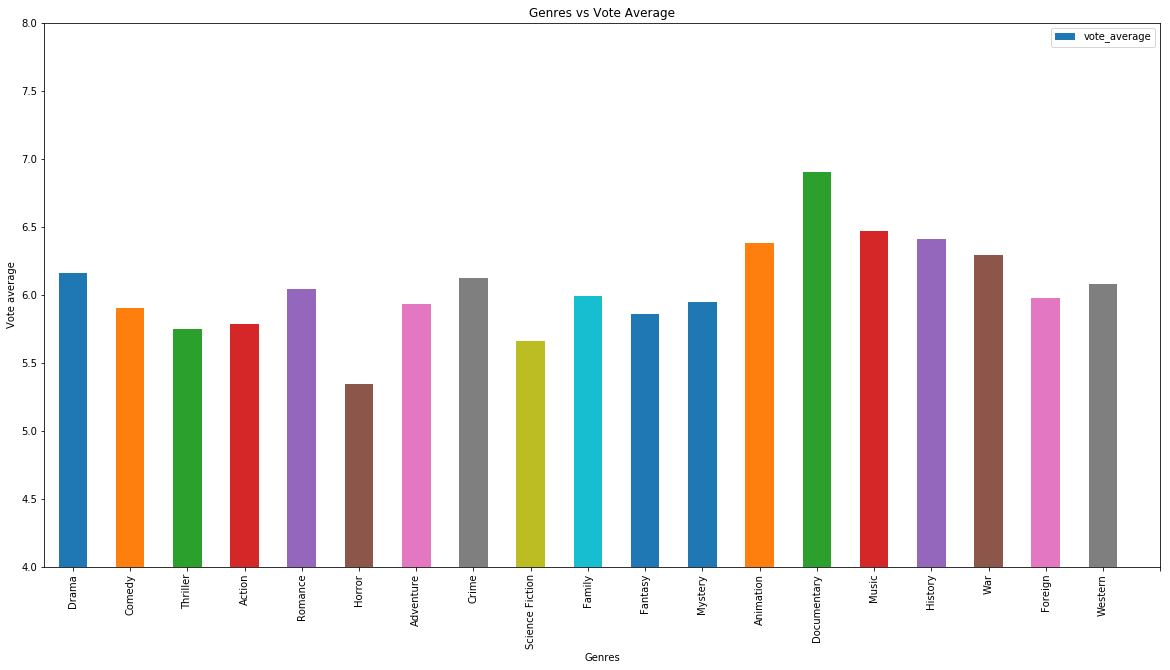

In [72]:
genres = expand_column(column_genres, column_vote_average, df_movies)
genres.plot(x = column_genres, y = column_vote_average, kind="bar", figsize=[20, 10])
plt.ylim(ymin=4, ymax=8)
plt.xticks(np.arange(20), genres[column_genres].values)
plt.ylabel("Vote average")
plt.xlabel("Genres")
plt.title("Genres vs Vote Average");

From one of the previous graphs, we could see that `Drama`, `Comedy`, `Thriller` and `Action` were genres with most number of movies. However, when it comes to `vote_average` they are almost close to the mean. Documentaries sees very less releases (by count) but it is the highest rated genre. Horror movies are the poorest rated. The behavior does not change even when looking at min or max value instead of mean. There are some outliers but they still adhere to the above correlation.

### Does vote average have any correlation with production companies ?

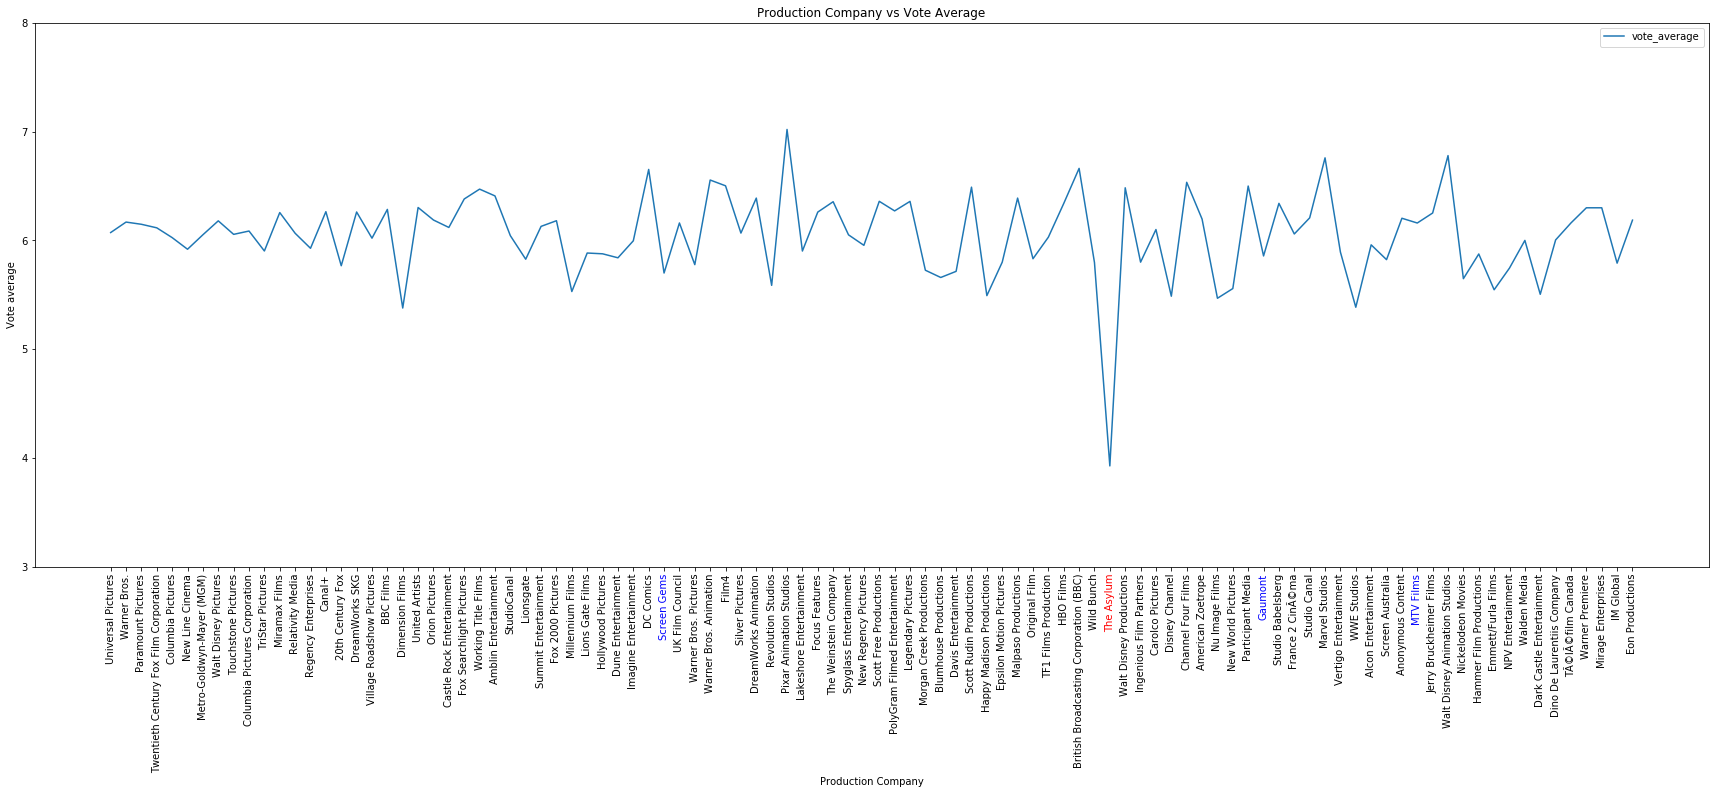

In [73]:
top_count = 100 # For this analysis consider only top 100 (by #number of movies produced) production studios.
production_companies = expand_column(column_production_companies, column_vote_average, df_movies, top_count)
production_companies.plot(x = column_production_companies, y = column_vote_average, kind="line", figsize=[30, 10])
plt.ylim(ymin=3, ymax=8)
plt.ylabel(column_vote_average)
plt.xticks(np.arange(top_count), production_companies[column_production_companies].values, rotation=90)

# highlight dips
plt.gca().get_xticklabels()[65].set_color("red")
# highlight ups
plt.gca().get_xticklabels()[36].set_color("blue")
plt.gca().get_xticklabels()[75].set_color("blue")
plt.gca().get_xticklabels()[85].set_color("blue")

plt.ylabel("Vote average")
plt.xlabel("Production Company")
plt.title("Production Company vs Vote Average");

Looking at above graph we can see that there are some consistent good performing studios like Pixar Animation Studios, Walt Disney Animation Studios etc. Also the top few studios (Which make the most number of movies if you refer to the earlier graphs) perform very close to average when it comes to `vote_average`. This is a typical Quantity vs Quality situation.

The Asylum seems to be the worst performer in top 100 production studios (by number of movies released). Again, there are some outliers (that can be seen when the above graph is replotted with `min()` or `max()` instead of `mean()` but those do adher to the above pattern closely. That being said, almost 40% of our dataset has null values for production_companies and this graph provides insights on only thise entries for which production studio value is present. **This is a very low confidence insight.** 

### Does vote average have any correlation with cast ?

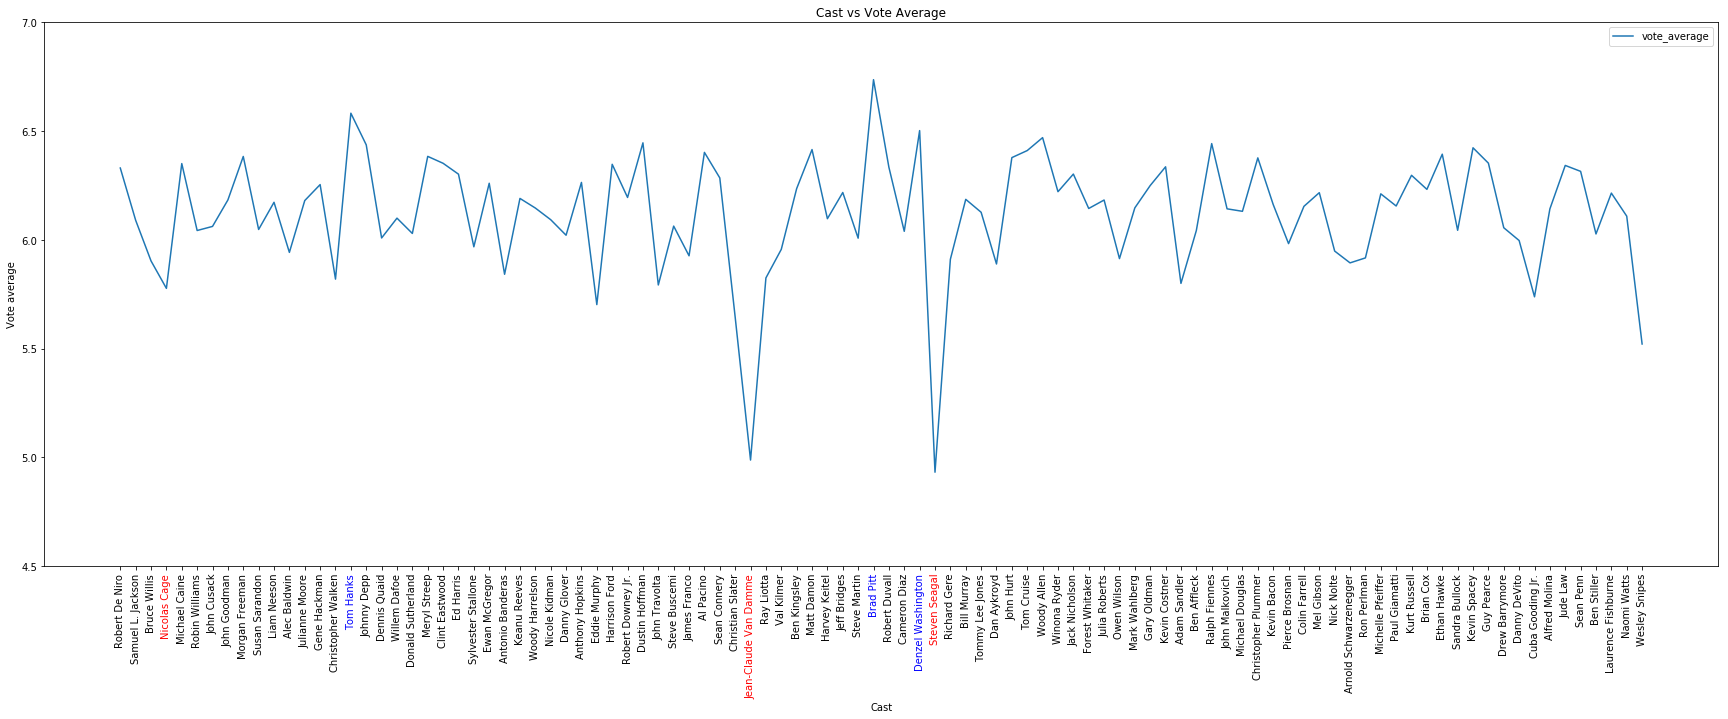

In [74]:
top_count = 100 # For this analysis consider only top 100 (by #number of movies) actors & actresses
cast = expand_column(column_cast, column_vote_average, df_movies, top_count)
cast.plot(x = column_cast, y = column_vote_average, kind="line", figsize=[30, 10])
plt.ylim(ymin=4.5, ymax=7)
plt.ylabel(column_vote_average)
plt.xticks(np.arange(top_count), cast[column_cast].values, rotation=90);

# highlight dips
plt.gca().get_xticklabels()[3].set_color("red")
plt.gca().get_xticklabels()[41].set_color("red")
plt.gca().get_xticklabels()[53].set_color("red")
# highlight ups
plt.gca().get_xticklabels()[15].set_color("blue")
plt.gca().get_xticklabels()[49].set_color("blue")
plt.gca().get_xticklabels()[52].set_color("blue")

plt.ylabel("Vote average")
plt.xlabel("Cast")
plt.title("Cast vs Vote Average");

The graph shows that for top 100 cast, actors like Tom Hanks, Brad Pitt and Denzel Washington seem to bring in good ratings for the movie while actors like Jean-Claude Van Dammme and Steven Seagal seem to perfom poorly. Also Nicholos Cage (who was #4 in terms of most number of movies) is one of the poor players.

When the above graph is replotted with `max()` instead of `mean()` same pattern is observed. If it is plotted with `min()` values, then Adam Sandler seems to have perfomed poorly (we can see a serious dip for Adam sandler in above graph as well but it becomes significant if plotted with min values)

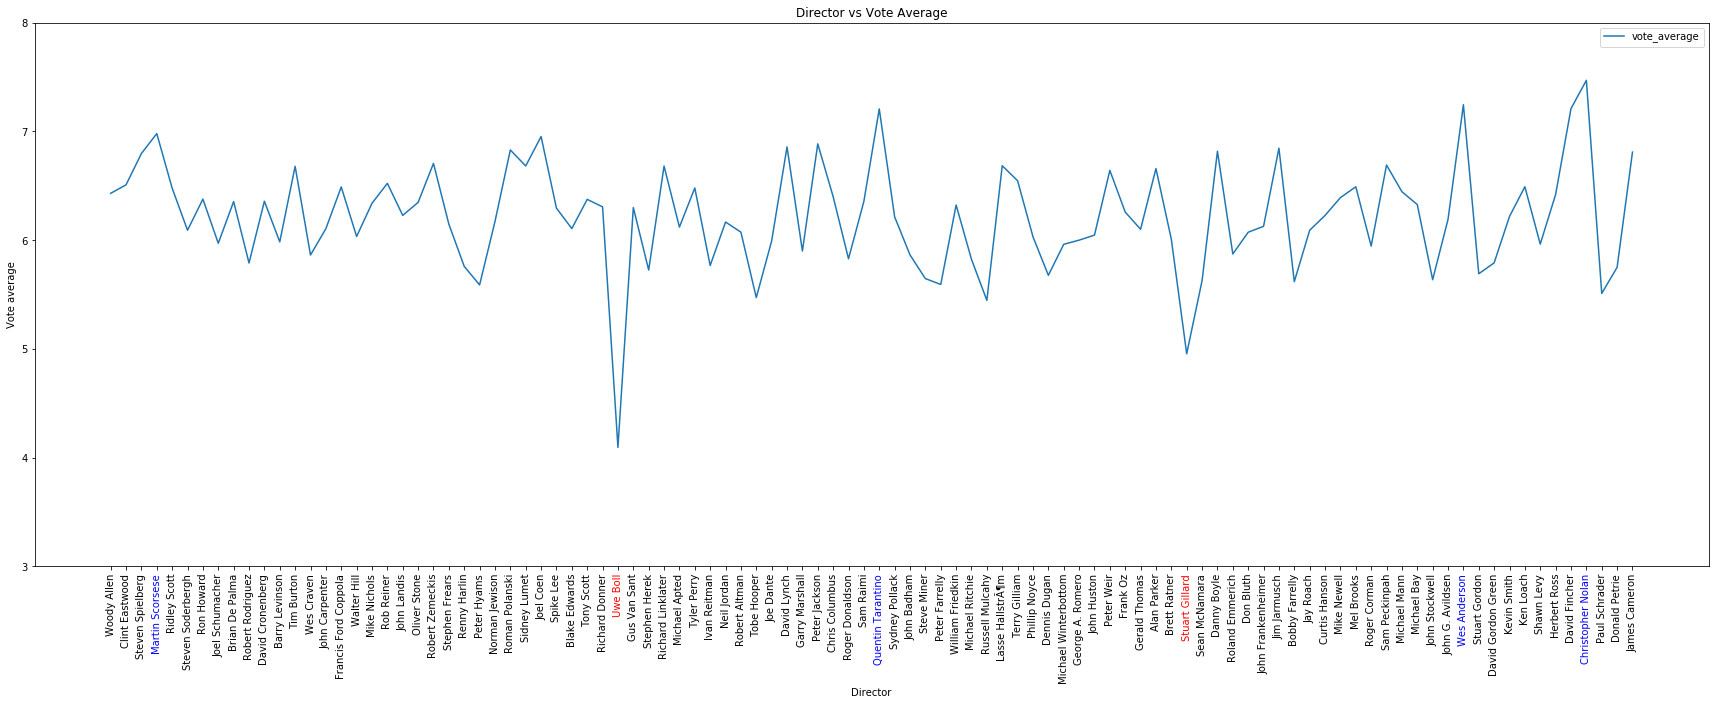

In [75]:
top_count = 100 # For this analysis consider only top 100 (by #number of movies) directors
director = expand_column(column_director, column_vote_average, df_movies, top_count)
director.plot(x = column_director, y = column_vote_average, kind="line", figsize=[30, 10])
plt.ylim(ymin=3, ymax=8)
plt.ylabel(column_vote_average)
plt.xticks(np.arange(top_count), director[column_director].values, rotation=90)

# highlight dips
plt.gca().get_xticklabels()[33].set_color("red")
plt.gca().get_xticklabels()[70].set_color("red")
# highlight ups
plt.gca().get_xticklabels()[3].set_color("blue")
plt.gca().get_xticklabels()[50].set_color("blue")
plt.gca().get_xticklabels()[88].set_color("blue")
plt.gca().get_xticklabels()[96].set_color("blue")

plt.ylabel("Vote average")
plt.xlabel("Director")
plt.title("Director vs Vote Average");

`Martin Scorsese, Quentin Tarantino, Wes Anderson, Christopher Nolan` seems to be highest performing directors in terms of ratings while `Uwe Boll` and `Stuart Gillard` seems to be the low performing directors.

While there are some directors who do consistently well with vote average there are some who do poorly. But as a 
overall theme most of the directors lie in the average range of 5.5 to 7.

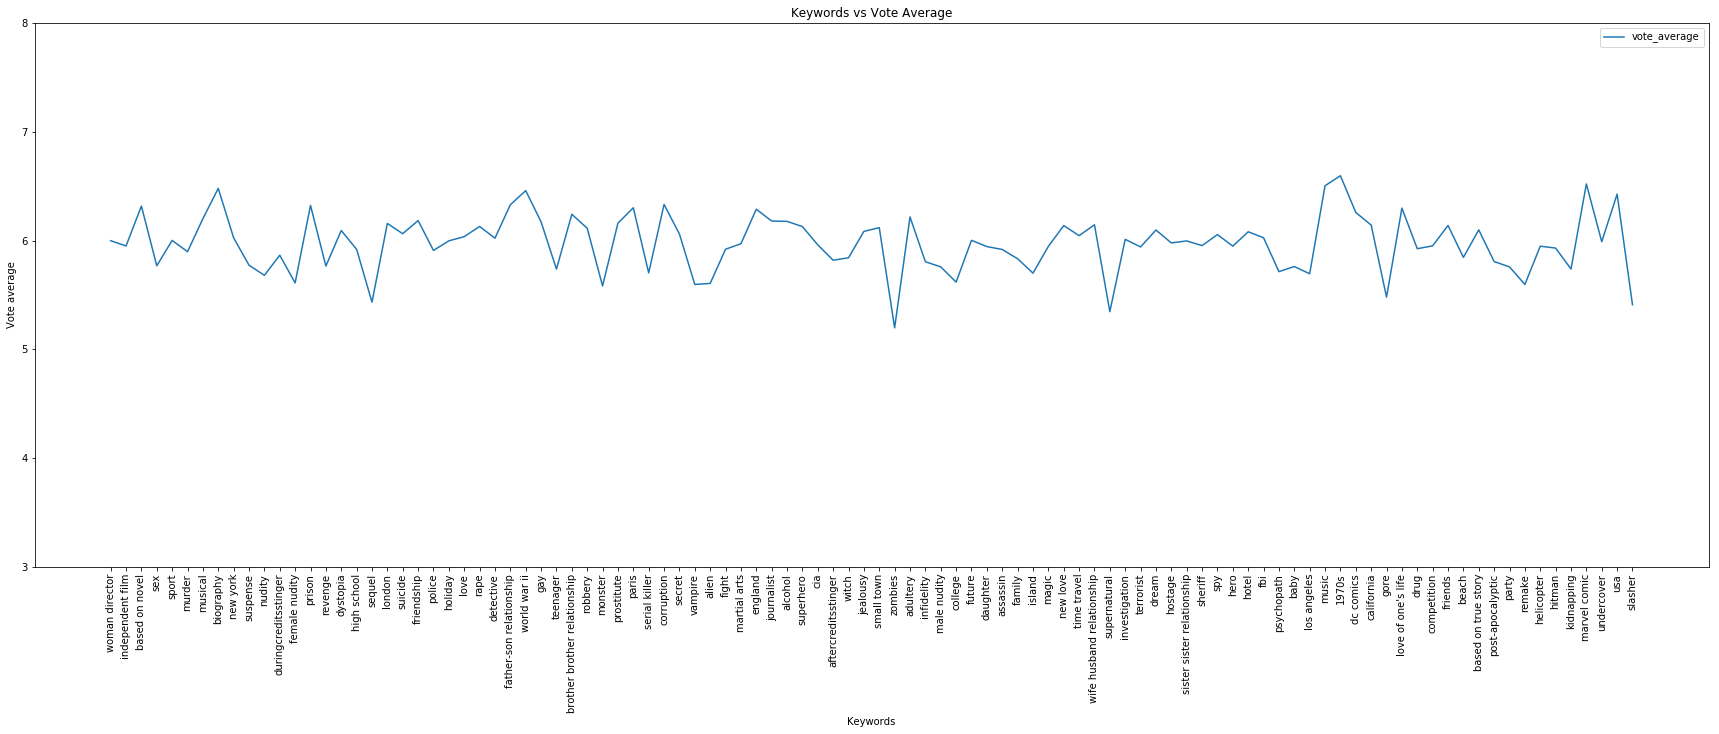

In [76]:
top_count = 100 # For this analysis consider only top 100 (by #number of movies) directors
column_keyword = "keywords"
keywords = expand_column(column_keyword, column_vote_average, df_movies, top_count)
keywords.plot(x = column_keyword, y = column_vote_average, kind="line", figsize=[30, 10])
plt.ylim(ymin=3, ymax=8)
plt.ylabel(column_vote_average)
plt.xticks(np.arange(top_count), keywords[column_keyword].values, rotation=90)

plt.ylabel("Vote average")
plt.xlabel("Keywords")
plt.title("Keywords vs Vote Average");

Although the keyword frequency graph provided an interesting insight that the top keywords was `women director` the correlation graph does not show any strong pattern in keywords and vote average relation.

### How does vote_average vary w.r.t runtime

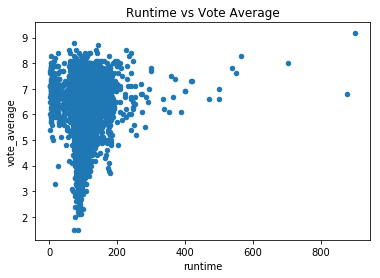

In [77]:
df_movies.plot(x="runtime", y="vote_average", kind="scatter")
plt.title("Runtime vs Vote Average");

There is a highly even distribution of movie runtimes between 0 and 200 minutes. Most of the movies lie in this range with few outliers execeeding 200 range and even fewer exceeding 400 minute range. Longer movies (> 400) almost always perform higher in vote_average. This could be probably because most of these are documentaries. That being said runtime does not provide any strong correlation with vote average except for the thought that very long movies recevie good ratings.

<a id='conclusions'></a>
## Conclusions

### Limitations

1. The dataset has null values for revenue columns for nearly 40% of the entries.
2. The dataset has null values for production_companies for nearly 1k entries (10% of the size).
3. The conclusions drawn above are done after the data has been cleaned(ie dropping null, missing values), if there    were complete data the conclusions might have a slight impact.
4. We considered `vote_average`, `vote_count`as our dependent variable to guage a movies's performance, however,  ratings could have been given by biased section of followers and revenue would have been a more accurate metric to consider.



### Recap of findings from our investigation

* The number of movies being released per year has consistently increased.
* Most number of movies are usually released during the second half of the year (September to January holiday season).
* Does movie release date month affect the vote average : NO.
* Any relation between the vote_count and the release month of the movie : NO.
* `Drama`, `Comedy`, `Action` and `Thriller` seems to be the most common genres.
* `Universal Pictures`, `Paramount`, and `Warner Bros` seems to be the production companies with highest releases.
* `Woody Allen`, `Client Eastwood`, `Martin Scorsese` and `Steven Spielberg` seems to be the directors with most number of movies.
* `Robert De Niro`, `Samuel L Jackson`, `Bruce Wills`, `Nicolas Cage` seems to be the top few actors. It is interesting to note that there are no actresses in top 10 (by count of movies). Also the diversity is missing in the sense that only a handful of actors get to perform in most number of movies.
* `woman director` is the most common keyword.

#### Multi-Variate Analysis
* `Documentaries` is the highest rated genre while `Horror` is the lowest rated genre.
* `Pixar Animation Studios`, `Walt Disney Animation Studios`, and `Marvel` seems to be the production studios making movies with highest ratings while `The Asylum` seems to be the poorest performer.
* Actors like `Tom Hanks`, `Brad Pitt`, and `Denzel Washington` seem to bring in good ratings for the movie while actors like `Jean-Claude Van Dammme` and `Steven Seagal` seem to perfom poorly. Also Nicholos Cage (who was #4 in terms of most number of movies) is one of the poor players.
* `Martin Scorsese, Quentin Tarantino, Wes Anderson, Christopher Nolan` seems to be highest performing directors in terms of ratings while `Uwe Boll` and `Stuart Gillard` seems to be the low performing directors.
* Most number of movies have a runtime in range of [50, 150]. Runtime does not have any strong correlation with vote average, however, extremely long runtimes (> 400) have always good vote averages.

In [78]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0